### Import modules and optimization functions:

In [1]:
from optimizer_ortools import optimizer
from matplotlib import pyplot as plt
import numpy as np

### Define some example day price profiles for the three markets:

In [2]:
daa_price_vector =  [35, 35, 35, 35, 33, 33, 33, 33, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33,
                    33, 33, 33, 33, 33, 33, 41, 41, 41, 41, 49, 49, 49, 49, 48, 48, 48, 48,
                    43, 43, 43, 43, 41, 41, 41, 41, 42, 42, 42, 42, 39, 39, 39, 39, 37, 37,
                    37, 37, 36, 36, 36, 36, 37, 37, 37, 37, 38, 38, 38, 38, 44, 44, 44, 44,
                    48, 48, 48, 48, 53, 53, 53, 53, 51, 51, 51, 51, 48, 48, 48, 48, 47, 47,
                    47, 47, 42, 42, 42, 42]


ida_price_vector =  [38, 36, 34, 35, 34, 35, 34, 31, 35, 29, 36, 37, 30, 33, 35, 39, 31, 34,
                    36, 36, 26, 27, 36, 46, 29, 42, 50, 53, 54, 52, 48, 43, 66, 54, 43, 29,
                    55, 43, 39, 31, 51, 39, 36, 31, 48, 40, 41, 34, 48, 36, 34, 35, 40, 39,
                    35, 30, 30, 32, 36, 39, 35, 39, 36, 40, 28, 35, 41, 48, 27, 36, 49, 60,
                    32, 43, 52, 67, 44, 50, 56, 62, 53, 52, 51, 49, 53, 52, 47, 43, 56, 49,
                    44, 35, 52, 44, 39, 33]


idc_price_vector =  [36, 44, 36, 28, 29, 27, 26, 25, 31, 32, 29, 28, 25, 28, 28, 31, 28, 25,
                    34, 36, 34, 34, 38, 41, 52, 52, 52, 51, 44, 64, 48, 47, 61, 53, 48, 40,
                    48, 33, 40, 42, 47, 36, 37, 34, 45, 37, 34, 30, 31, 27, 26, 28, 30, 27,
                    22, 17, 26, 29, 24, 21, 19, 21, 21, 23, 20, 27, 32, 34, 30, 23, 27, 37,
                    26, 31, 33, 42, 25, 38, 37, 42, 43, 44, 40, 44, 43, 46, 46, 44, 48, 46,
                    41, 35, 43, 37, 31, 32]

### Show example day price profiles:

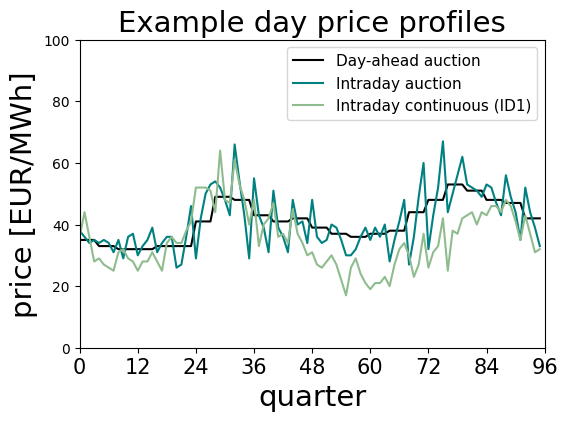

In [3]:
plt.figure(figsize=(6,4))

plt.plot(daa_price_vector,label='Day-ahead auction', color='black')
plt.plot(ida_price_vector,label='Intraday auction', color='teal')
plt.plot(idc_price_vector,label='Intraday continuous (ID1)',color='darkseagreen')

plt.title('Example day price profiles', fontsize=21)

plt.xlim(0,96)
plt.xticks([0,12,24,36,48,60,72,84,96],fontsize=15)
plt.xlabel('quarter',fontsize=21)

plt.ylim(0,100)
plt.yticks()
plt.ylabel('price [EUR/MWh]',fontsize=21)

plt.legend(fontsize=11)

### Sequentially optimize: DA Auction, then ID Auction, then ID Continuous

In [4]:
energy_cap = 2
power_cap = 1
n_cycles = 1.5

In [5]:
opt = optimizer()

soc1, cha1, dis1, p1 = opt.step1_optimize_daa(
    n_cycles, energy_cap, power_cap, daa_price_vector
)

soc2, cha2, dis2, cha2c, dis2c, p2, cha_tot2, dis_tot2 = opt.step2_optimize_ida(
    n_cycles, energy_cap, power_cap, ida_price_vector, cha1, dis1
)

soc3, cha3, dis3, cha3c, dis3c, p3, cha_tot3, dis_tot3 = opt.step3_optimize_idc(
    n_cycles, energy_cap, power_cap, idc_price_vector, cha_tot2, dis_tot2
)

print("DAA profit:", round(p1,2))
print("IDA profit:", round(p2,2))
print("IDC profit:", round(p3,2))
print("TOTAL:", round(p1+p2+p3,2))


DAA profit: 53.0
IDA profit: 34.75
IDC profit: 36.75
TOTAL: 124.5


### Calculate revenue on the three markets and total revenue:

In [8]:
revenue_daa = np.sum(np.asarray(daa_price_vector) * (np.asarray(dis1) - cha1)) * power_cap/4
revenue_ida = np.sum(np.asarray(ida_price_vector) * (np.asarray(dis2) + dis2c - cha2 - cha2c)) * power_cap/4
revenue_idc = np.sum(np.asarray(idc_price_vector) * (np.asarray(dis3) + dis3c - cha3 - cha3c)) * power_cap/4

revenue_total = revenue_daa+revenue_ida+revenue_idc

### Plot example day optimal schedule:

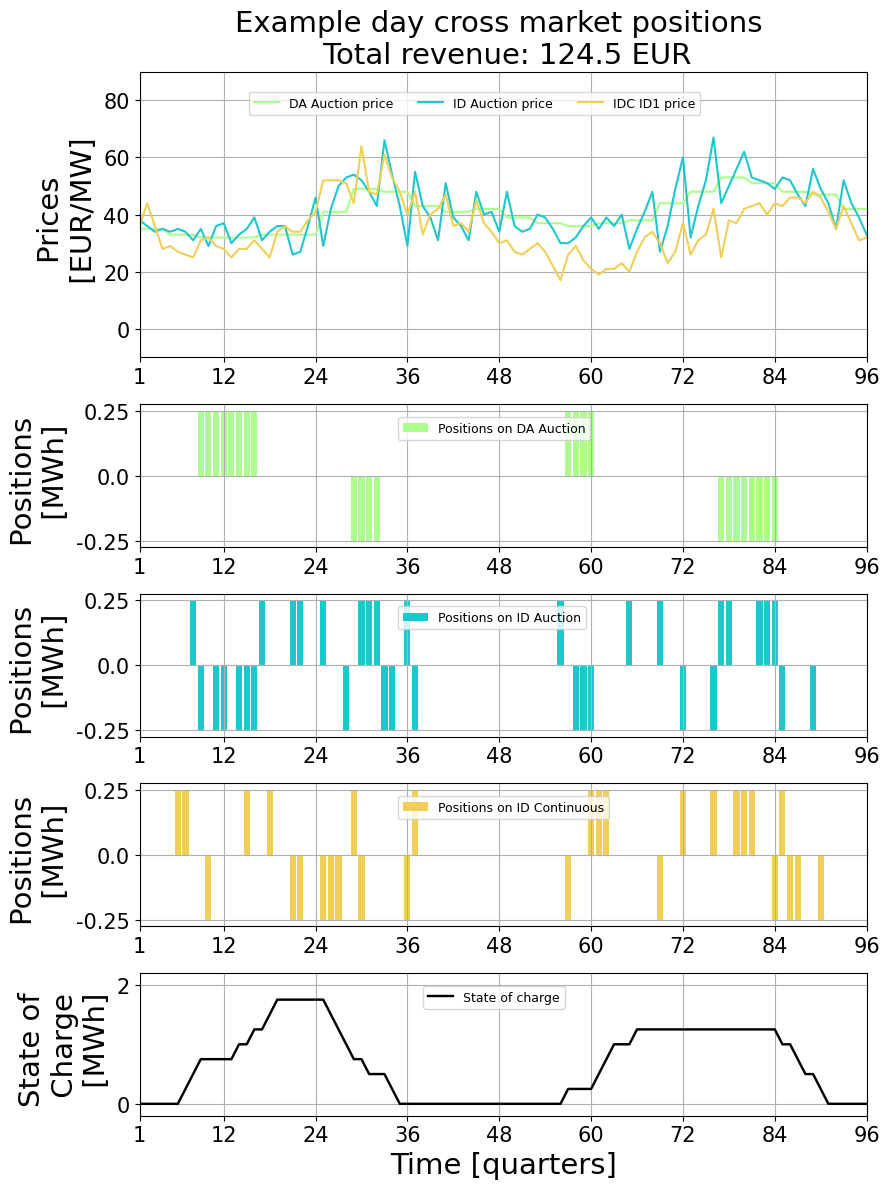

In [10]:
color1 = (170/255,1,142/255,1)
color2 = (28/255,200/255,206/255,1)
color3 = (241/255,207/255,87/255,1)


xgrid = np.arange(1, 97, 1)

fig, axs = plt.subplots(5, 1, figsize=(9, 12), gridspec_kw={'height_ratios': [2,1,1,1,1]})

ax1, ax2, ax3, ax4, ax5 = axs


# Subplot 1

ax1.plot(xgrid, daa_price_vector, color=color1, label='DA Auction price')
ax1.plot(xgrid, ida_price_vector, color=color2, label='ID Auction price')
ax1.plot(xgrid, idc_price_vector, color=color3, label='IDC ID1 price')

ax1.legend(fontsize=9,ncol=4, loc=(0.15,0.85))
ax1.grid()
ax1.set_xlim(1, len(ida_price_vector))
ax1.set_xticks([1, 12, 24, 36, 48, 60, 72, 84, 96])
ax1.set_xticklabels([1, 12, 24, 36, 48, 60, 72, 84, 96], fontsize=15)
ax1.set_yticks([0,20,40,60,80])
ax1.set_yticklabels([0,20,40,60,80], fontsize=15)
ax1.set_ylim(-10, 90)
ax1.set_ylabel('Prices \n [EUR/MW]', fontsize=21)
ax1.set_title(f'Example day cross market positions \n Total revenue: {revenue_total} EUR', fontsize=21)


# Subplot 2

ax2.bar(xgrid, np.asarray(cha1)*power_cap/4, color=color1, label='Positions on DA Auction', linewidth=1.75)
ax2.bar(xgrid, np.asarray(dis1)*-power_cap/4, color=color1, linewidth=1.75)

ax2.legend(fontsize=9,ncol=4, loc=(0.355,0.75))
ax2.grid()
ax2.set_xlim(1, len(ida_price_vector))
ax2.set_xticks([1, 12, 24, 36, 48, 60, 72, 84, 96])
ax2.set_xticklabels([1, 12, 24, 36, 48, 60, 72, 84, 96], fontsize=15)
ax2.set_ylim(-power_cap/4*1.1, power_cap/4*1.1)
ax2.set_yticks([-power_cap/4,0, power_cap/4])
ax2.set_yticklabels(ax2.get_yticks(), fontsize=15)
ax2.set_ylabel('Positions \n [MWh]', fontsize=21)


# Subplot 3

ax3.bar(xgrid, np.asarray(cha2)*power_cap/4, color=color2, label='Positions on ID Auction', linewidth=1.75)
ax3.bar(xgrid, np.asarray(dis2)*-power_cap/4, color=color2, linewidth=1.75)
ax3.bar(xgrid, np.asarray(cha2c)*power_cap/4, color=color2, linewidth=1.75)
ax3.bar(xgrid, np.asarray(dis2c)*-power_cap/4, color=color2, linewidth=1.75)

ax3.legend(fontsize=9,ncol=4, loc=(0.355,0.75))
ax3.grid()
ax3.set_xlim(1, len(ida_price_vector))
ax3.set_xticks([1, 12, 24, 36, 48, 60, 72, 84, 96])
ax3.set_xticklabels([1, 12, 24, 36, 48, 60, 72, 84, 96], fontsize=15)
ax3.set_ylim(-power_cap/4*1.1, power_cap/4*1.1)
ax3.set_yticks([-power_cap/4,0, power_cap/4])
ax3.set_yticklabels(ax2.get_yticks(), fontsize=15)
ax3.set_ylabel('Positions \n [MWh]', fontsize=21)


# Subplot 4

ax4.bar(xgrid, np.asarray(cha3)*power_cap/4, color=color3, label='Positions on ID Continuous', linewidth=1.75)
ax4.bar(xgrid, np.asarray(dis3)*-power_cap/4, color=color3, linewidth=1.75)
ax4.bar(xgrid, np.asarray(cha3c)*power_cap/4, color=color3, linewidth=1.75)
ax4.bar(xgrid, np.asarray(dis3c)*-power_cap/4, color=color3, linewidth=1.75)

ax4.legend(fontsize=9,ncol=4, loc=(0.355,0.75))
ax4.grid()
ax4.set_xlim(1, len(ida_price_vector))
ax4.set_xticks([1, 12, 24, 36, 48, 60, 72, 84, 96])
ax4.set_xticklabels([1, 12, 24, 36, 48, 60, 72, 84, 96], fontsize=15)
ax4.set_ylim(-power_cap/4*1.1, power_cap/4*1.1)
ax4.set_yticks([-power_cap/4,0, power_cap/4])
ax4.set_yticklabels(ax2.get_yticks(), fontsize=15)
ax4.set_ylabel('Positions \n [MWh]', fontsize=21)


# Subplot 5

ax5.plot(xgrid, soc3, color='black', label='State of charge', linewidth=1.75)

ax5.legend(fontsize=9,ncol=4, loc=(0.39,0.75))
ax5.grid()
ax5.set_xlim(1, len(ida_price_vector))
ax5.set_xticks([1, 12, 24, 36, 48, 60, 72, 84, 96])
ax5.set_xticklabels([1, 12, 24, 36, 48, 60, 72, 84, 96], fontsize=15)
ax5.set_xlabel('Time [quarters]', fontsize=21)
ax5.set_ylim(-0.2, energy_cap*1.1)
ax5.set_yticks([0, energy_cap])
ax5.set_yticklabels(ax5.get_yticks(), fontsize=15)
ax5.set_ylabel('State of \n Charge \n [MWh]', fontsize=21)

plt.tight_layout()
plt.show()
